In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline

# Set the task and experiment type
task_name = 'swda'
base_url = 'https://raw.github.com/NathanDuran/Switchboard-Corpus/master/swda_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Use Punctuation
Whether to remove punctuation from the input sentences or not.

Show punctuation flag value corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'use_punct'

# Load punctuation experiment data
punc_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
punc_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
punc_data_max = get_max(punc_mean_data, [exp_param])
punc_data_max

Best validation accuracy in mean data:
   model_name  use_punct    val_acc  val_acc_std
15   text cnn       True  75.611012     0.253492
Best test accuracy in mean data:
  model_name  use_punct   test_acc  test_acc_std  f1_micro  f1_micro_std
7       dcnn       True  72.798016       0.49409  0.729542       0.00504


,model_name,use_punct,val_acc,val_acc_std,use_punct,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,True,72.919157,0.460366,True,71.549156,0.501060,0.717112,0.005142
1,bi lstm,True,74.879420,0.218904,True,72.283205,0.751516,0.724344,0.007768
2,cnn,True,74.459764,0.233043,True,71.526531,0.542116,0.716524,0.005334
3,dcnn,True,75.017612,0.123893,True,72.798016,0.494090,0.729542,0.005040
4,gru,True,73.697411,0.242854,True,71.436037,0.896480,0.715837,0.008945
5,lstm,True,75.251976,0.177242,True,72.339683,0.541421,0.724884,0.005451
6,rcnn,True,74.061644,0.451766,True,71.998157,0.579423,0.721500,0.005800
7,text cnn,True,75.611012,0.253492,True,72.790529,0.331333,0.729272,0.003362


Plot accuracy of each model per punctuation flag value.

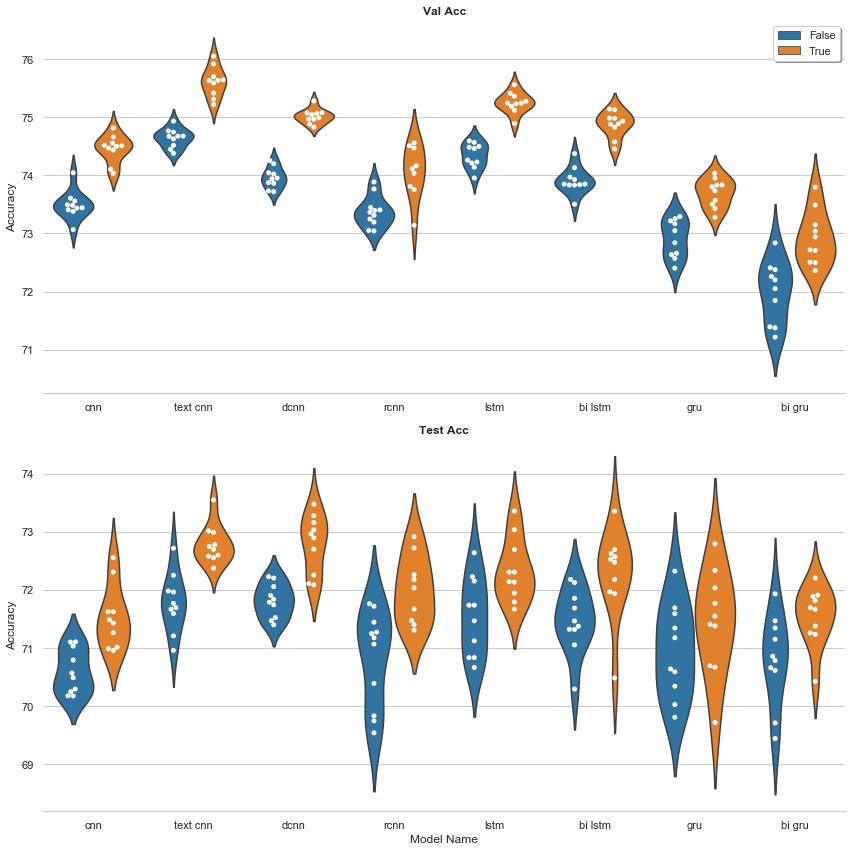

In [3]:
# TODO remove test data
# Get test and validation accuracy for each model
punc_acc_data = punc_data.drop(punc_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
punc_acc_data = punc_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
punc_acc_data = punc_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(punc_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                            num_legend_col=1, y_label='Accuracy', x_label='Model Name',
                            share_y=False, num_col=1, dodge=True, colour='default')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform t-test comparing punctuation true and false for each model.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(punc_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(punc_data, exp_param, metric)

# Run t-test
t_test(punc_data, exp_param, metric)

All models use_punct are normally distributed.
All models use_punct have equal variance.
All models have significant p-values when comparing use_punct groups.


,model_name,t-stat,p-value
0,cnn,-9.093682,3.774000e-08
1,text cnn,-10.175668,6.826824e-09
2,dcnn,-15.490012,7.518729e-12
3,rcnn,-4.263384,4.675678e-04
4,lstm,-10.489057,4.262169e-09
5,bi lstm,-9.742328,1.332627e-08
6,gru,-6.132616,8.599319e-06
7,bi gru,-4.163449,5.837580e-04


# Letter Case
Whether to lowercase all words from the input sentences or not.

Show lowercase flag value corresponding to max validation and test accuracy per model.

In [5]:
# Name of the experiment parameter for comparison
exp_param = 'to_lower'

# Load punctuation experiment data
lcase_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
lcase_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lcase_mean_data.loc[[lcase_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lcase_mean_data.loc[[lcase_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
lcase_data_max = get_max(lcase_mean_data, [exp_param])
lcase_data_max

Best validation accuracy in mean data:
   model_name  to_lower    val_acc  val_acc_std
15   text cnn      True  75.333085     0.228255
Best test accuracy in mean data:
   model_name  to_lower  test_acc  test_acc_std  f1_micro  f1_micro_std
11       lstm      True   72.7417      0.573446  0.728862      0.005725


,model_name,to_lower,val_acc,val_acc_std,to_lower,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,True,73.903287,0.344537,True,71.649692,0.555854,0.718146,0.005615
1,bi lstm,True,74.893695,0.223282,True,72.341307,0.631891,0.725061,0.006256
2,cnn,True,74.733102,0.191275,False,71.802456,0.511126,0.719397,0.004977
3,dcnn,True,74.542848,0.192968,True,72.328054,0.706065,0.724644,0.007107
4,gru,False,74.283770,0.397417,True,71.825125,0.358990,0.719814,0.003625
5,lstm,True,75.241599,0.198041,True,72.741700,0.573446,0.728862,0.005725
6,rcnn,True,74.459952,0.293927,True,71.923477,0.464810,0.720770,0.004595
7,text cnn,True,75.333085,0.228255,True,72.677176,0.366872,0.728151,0.003586


Plot accuracy of each model per lowercase flag value.

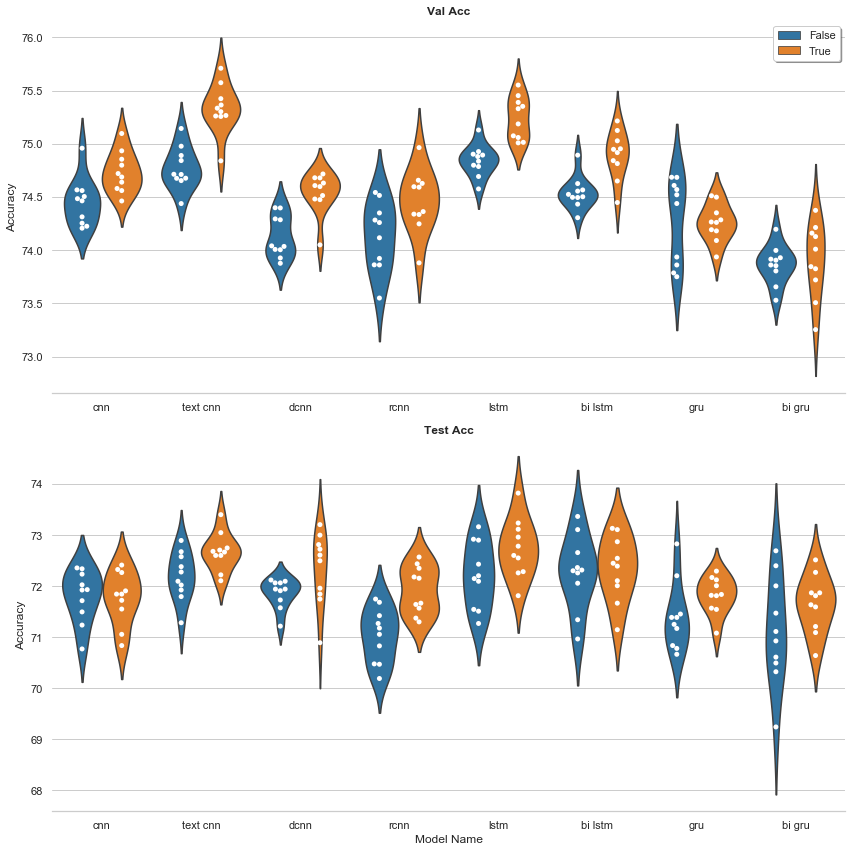

In [6]:
# TODO remove test data
# Get test and validation accuracy for each model
lcase_acc_data = lcase_data.drop(lcase_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lcase_acc_data = lcase_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lcase_acc_data = lcase_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lcase_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                            num_legend_col=1, y_label='Accuracy', x_label='Model Name',
                            share_y=False, num_col=1, dodge=True, colour='default')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform t-test comparing lowercase true and false for each model.

In [7]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(lcase_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(lcase_data, exp_param, metric)

# Run t-test
t_test(lcase_data, exp_param, metric)

The following to_lower are not normally distributed.
   model_name to_lower    t-stat   p-value
5        dcnn     True  0.768321  0.005966
12        gru    False  0.810507  0.019448
The following models to_lower do not have equal variance.
  model_name   t-stat   p-value
6        gru  4.52943  0.047387
The following models do not have significant p-values when comparing to_lower groups.
  model_name    t-stat   p-value
6        gru  0.194925  0.847635
7     bi gru -0.314642  0.756652


,model_name,t-stat,p-value
0,cnn,-2.996210,0.007749
1,text cnn,-5.882048,0.000014
2,dcnn,-4.780535,0.000150
3,rcnn,-2.425500,0.026026
4,lstm,-5.116183,0.000072
5,bi lstm,-4.156024,0.000593
6,gru,0.194925,0.847635
7,bi gru,-0.314642,0.756652


# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [8]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max

Best validation accuracy in mean data:
    model_name  vocab_size    val_acc  val_acc_std
122   text cnn        5500  75.611698     0.252162
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_micro  f1_micro_std
84       lstm        2500  72.904949       0.46696  0.730449      0.004681


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,4000,73.130540,0.288800,8000,71.847007,0.491440,0.720103,0.004952
1,bi lstm,8000,74.976895,0.232023,8000,72.805991,0.389276,0.729566,0.003932
2,cnn,2500,74.497464,0.236102,7500,71.849122,0.633302,0.719735,0.006126
3,dcnn,7500,75.153113,0.127858,8000,72.697104,0.611036,0.728389,0.006015
4,gru,8000,73.890404,0.359925,6500,71.943525,0.384998,0.720961,0.003963
5,lstm,7000,75.247198,0.182265,2500,72.904949,0.466960,0.730449,0.004681
6,rcnn,7500,74.360639,0.491259,7000,71.769208,0.797098,0.719294,0.007987
7,text cnn,5500,75.611698,0.252162,2500,72.853354,0.362296,0.729958,0.003651


Plot accuracy of each model per vocabulary size.

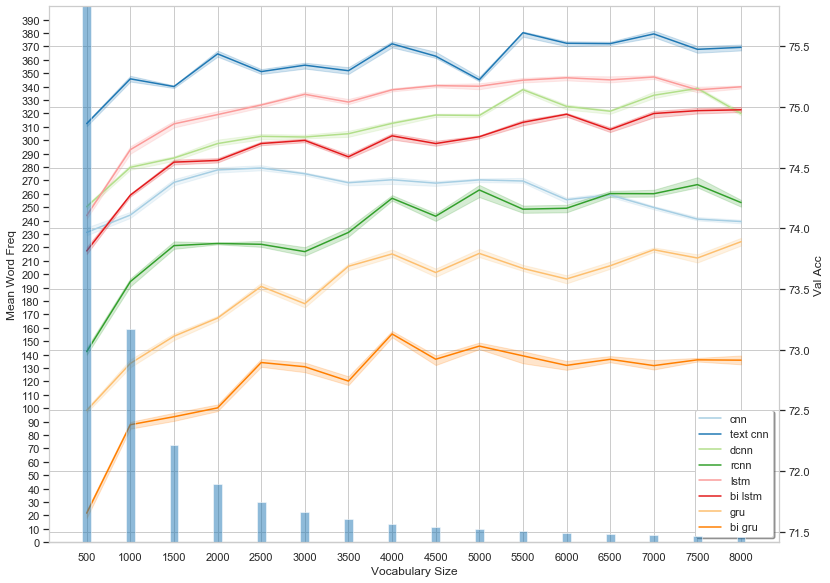

In [9]:
# TODO remove test data
# Get test and validation accuracy for each model
# vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# g, fig = plot_relplot(vocab_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:8000]
ind_start, ind_end = 0, 500
freq_dict = dict()
for i in range(16):
    freq_dict[ind_end] = word_freq.loc[ind_start:ind_end].mean() # Binning
    # freq_dict[ind_end] = word_freq.loc[0:ind_end].sum() # Cumulative summming
    ind_start += 500
    ind_end += 500
word_freq = pd.DataFrame.from_dict(freq_dict, orient='index')
word_freq.reset_index(level=0, inplace=True)
word_freq.rename(columns={'index': 'vocab_size'}, inplace=True)

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, word_freq, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=10, bar_axis_range=[0, 400], bar_width=100,
                          bar_y_label='Mean Word Freq', bar_alpha=0.5, bar_color='tab:blue', legend_loc='best', num_legend_col=1)

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different vocabulary size groups.

In [10]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825525  0.029552
50       rcnn       1500  0.838141  0.041918
62       rcnn       7500  0.753438  0.003930
76       lstm       6500  0.815660  0.022456
87    bi lstm       4000  0.814243  0.021585
All models vocab_size have equal variance.
All models have significant p-values when comparing vocab_size groups.


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,4.155192,15.0,0.277013,5.326351,2.025392e-08,0.356842,0.288558
text cnn,5.636247,15.0,0.375750,6.178238,6.645045e-10,0.391567,0.326808
dcnn,9.822078,15.0,0.654805,15.746608,1.838878e-23,0.621251,0.580272
rcnn,18.759833,15.0,1.250656,10.350516,1.795819e-16,0.518809,0.467124
lstm,12.930942,15.0,0.862063,17.218715,3.891193e-25,0.642041,0.603254
bi lstm,13.358382,15.0,0.890559,18.407561,1.987861e-26,0.657235,0.620055
gru,22.173895,15.0,1.478260,14.953782,1.597458e-22,0.609022,0.566756
bi gru,19.179585,15.0,1.278639,10.018167,5.446340e-16,0.510658,0.458128


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

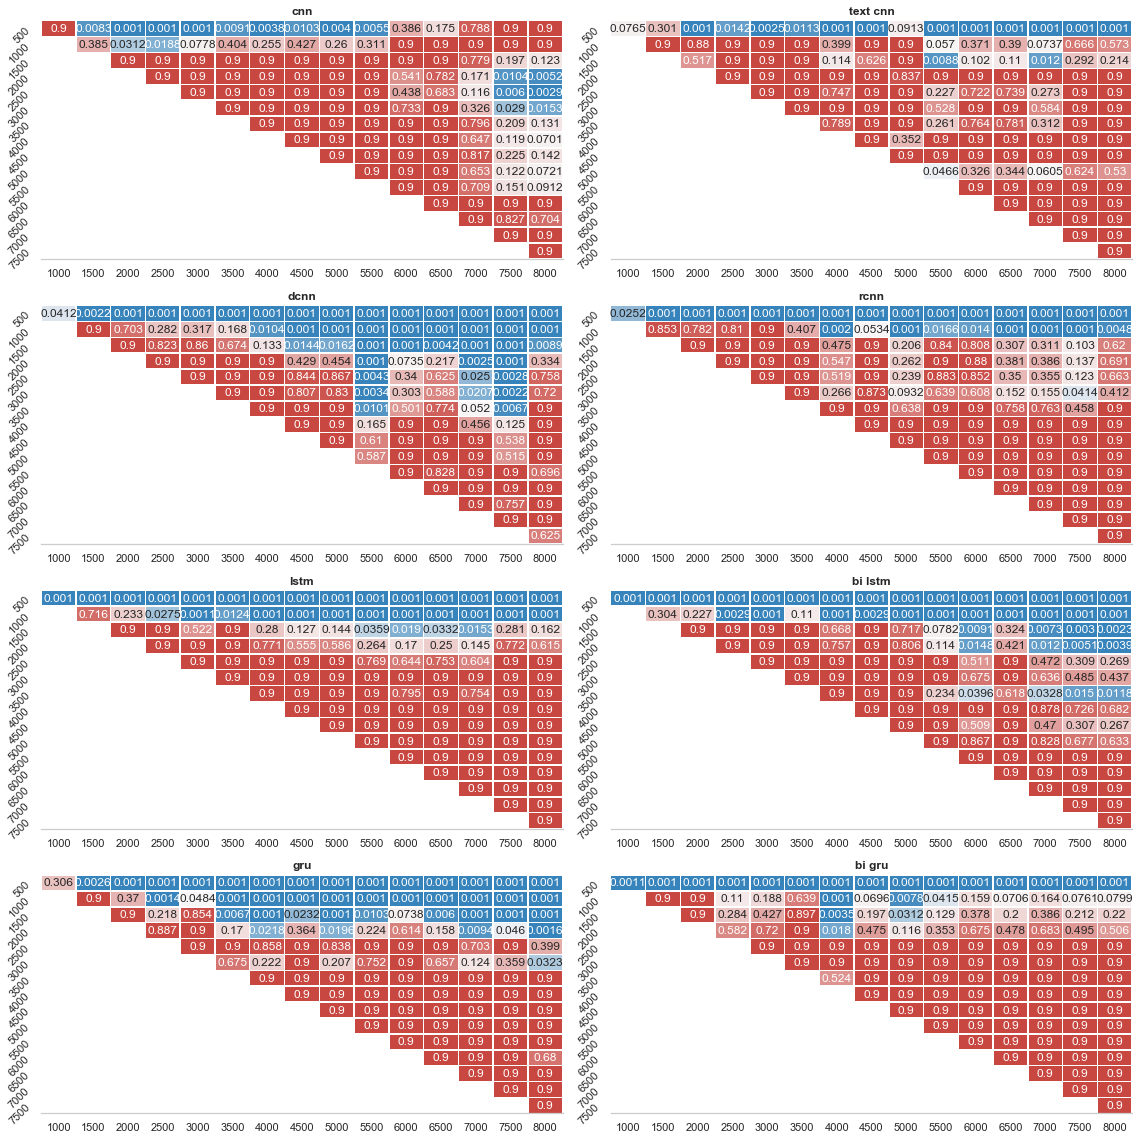

In [11]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 5000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [12]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
74   text cnn              25  75.633028      0.24392
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_micro  f1_micro_std
59       lstm              50  72.914715      0.277824  0.730547      0.002765


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,30,73.505664,0.291339,50,72.042970,0.523714,0.722015,0.005130
1,bi lstm,35,74.855287,0.153692,50,72.307619,0.829299,0.724589,0.008263
2,cnn,45,74.429969,0.169785,35,71.781578,0.428486,0.719196,0.004261
3,dcnn,30,75.101601,0.231578,35,72.675131,0.252354,0.728169,0.002581
4,gru,25,73.944922,0.265093,40,72.105471,0.378416,0.722726,0.003784
5,lstm,25,75.349592,0.159436,50,72.914714,0.277824,0.730547,0.002765
6,rcnn,40,74.499347,0.280902,50,72.198570,0.427266,0.723633,0.004227
7,text cnn,25,75.633028,0.243920,20,72.820802,0.284977,0.729493,0.002942


Plot accuracy of each model per sequence length.

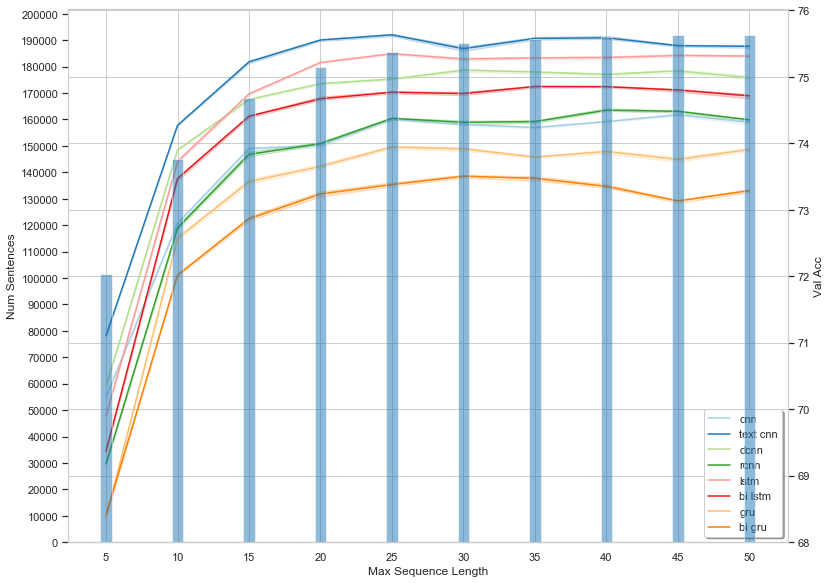

In [13]:
# TODO remove test data
# Get test and validation accuracy for each model
# seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])
#
# g, fig = plot_relplot(seq_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Sequence Length',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Bin into same values as experiment
ind_start, ind_end = 0, 5
freq_dict = dict()
for i in range(10):
    # freq_dict[ind_end] = sent_lengths.loc[ind_start:ind_end].sum()
    freq_dict[ind_end] = sent_lengths.loc[0:ind_end].sum() # Cumulative sum
    ind_start += 5
    ind_end += 5
sent_lengths = pd.DataFrame.from_dict(freq_dict, orient='index')
sent_lengths.reset_index(level=0, inplace=True)
sent_lengths.rename(columns={'index': 'max_seq_length', 0: 'Count'}, inplace=True)

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sent_lengths, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=10000, bar_axis_range=None, bar_width=0.8,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue', legend_loc='lower right', num_legend_col=1)

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different sequence length groups.

In [14]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

The following max_seq_length are not normally distributed.
   model_name max_seq_length    t-stat   p-value
4         cnn             25  0.779160  0.008086
17   text cnn             40  0.817419  0.023584
61        gru             10  0.819752  0.025168
78     bi gru             45  0.700521  0.000894
All models max_seq_length have equal variance.
All models have significant p-values when comparing max_seq_length groups.


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,156.994288,9.0,17.443810,364.465080,8.926812e-67,0.973295,0.970337
text cnn,177.002078,9.0,19.666898,372.079519,3.614924e-67,0.973827,0.970928
dcnn,194.943510,9.0,21.660390,480.181912,4.985668e-72,0.979599,0.977338
rcnn,243.302778,9.0,27.033642,374.900643,2.597900e-67,0.974019,0.971141
lstm,262.223599,9.0,29.135955,760.126463,7.580867e-81,0.987015,0.985574
bi lstm,260.520442,9.0,28.946716,428.025018,7.810157e-70,0.977170,0.974640
gru,265.610882,9.0,29.512320,323.453113,1.631616e-64,0.970011,0.966690
bi gru,218.615634,9.0,24.290626,239.557288,7.261034e-59,0.959929,0.955497


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

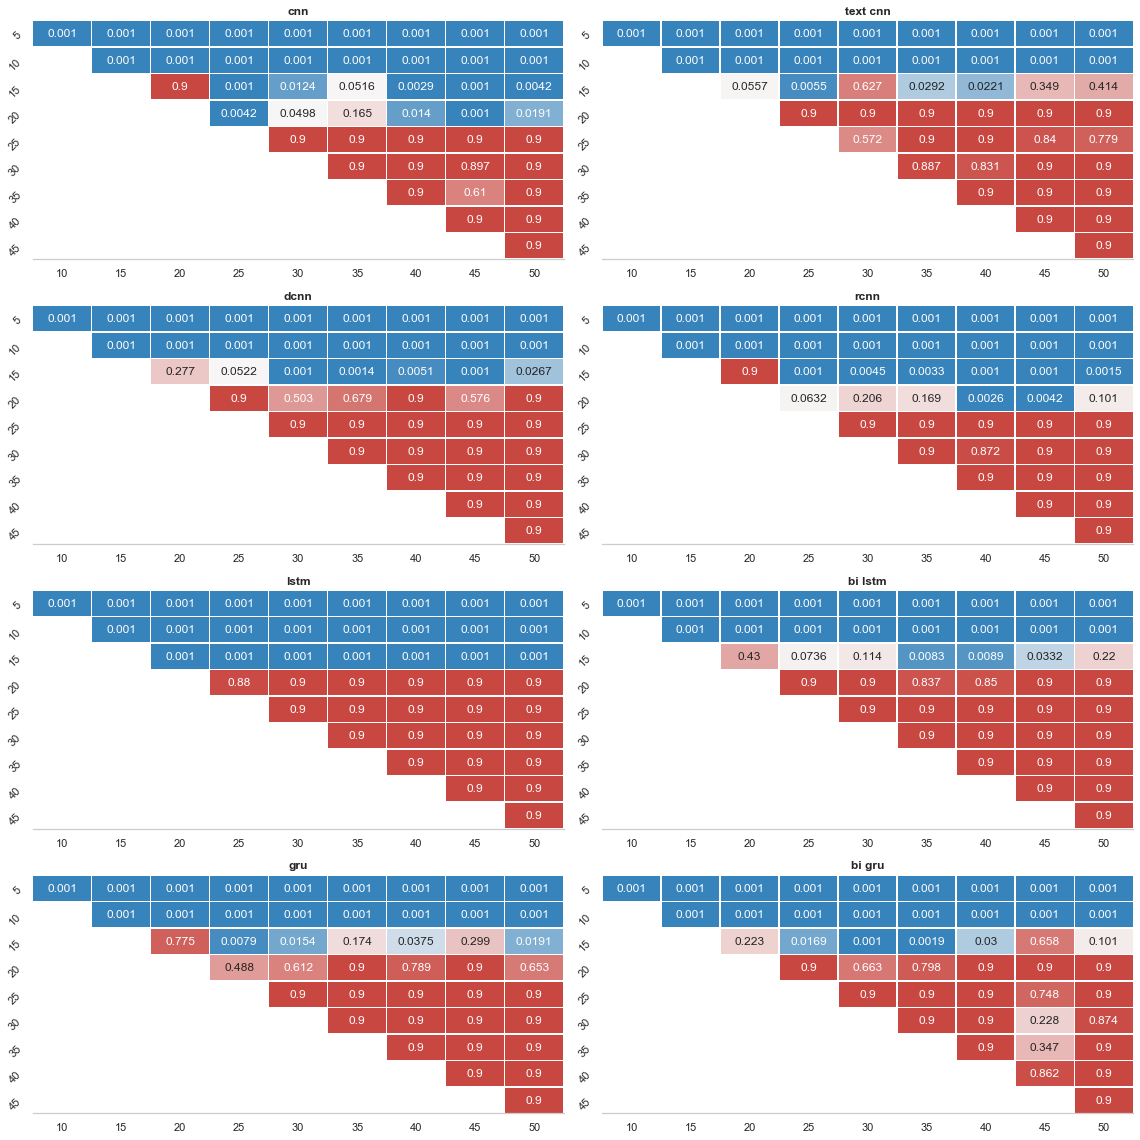

In [15]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Input Sequence Combinations

Compare vocabulary size (2.5k, 5k or 10k words) and sequence lengths (25, 50 or 128 tokens).

In [16]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max

Best validation accuracy in mean data:
   model_name  vocab_size  max_seq_length    val_acc  val_acc_std
21   text cnn        2500              25  75.408257      0.08534
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length   test_acc  test_acc_std  f1_micro  f1_micro_std
17       lstm       10000             128  72.901694      0.499982  0.730277      0.005044


,model_name,vocab_size,max_seq_length,val_acc,val_acc_std,vocab_size,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,5000,50,73.989522,0.242689,10000,128,71.577844,0.533301,0.717361,0.005320
1,bi lstm,5000,50,74.907185,0.247792,10000,128,72.226910,0.555104,0.723786,0.005573
2,cnn,5000,50,74.858151,0.235315,10000,128,71.867513,0.453122,0.719809,0.004564
3,dcnn,5000,50,74.677440,0.243719,10000,128,72.378745,0.479549,0.725276,0.004872
4,gru,5000,50,74.370473,0.165475,10000,128,71.877280,0.627865,0.720324,0.006300
5,lstm,10000,128,75.348231,0.148951,10000,128,72.901694,0.499982,0.730277,0.005044
6,rcnn,10000,128,74.510035,0.167624,10000,128,71.896161,0.517487,0.720569,0.005232
7,text cnn,2500,25,75.408257,0.085340,10000,128,72.627443,0.633320,0.727801,0.006293


Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA comparing vocabulary size (2.5k, 5k or 10k words) and sequence lengths (25, 50 or 128 tokens) for each model.

NOTE:
- t-test comparing 'V=2.5k_S=25' and 'V=10k_S=128' only lstm shows significant difference.
- t-test comparing 'V=5k_S=50' and 'V=10k_S=128' no model shows significant difference.

In [17]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 2500) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 128)]
choices = ['V=2.5k_S=25', 'V=5k_S=50', 'V=10k_S=128']
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(inseq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(inseq_data, exp_param, metric)

The following exp_params are not normally distributed.
   model_name   exp_params    t-stat   p-value
11       rcnn  V=2.5k_S=25  0.826745  0.030571
The following models exp_params do not have equal variance.
  model_name    t-stat   p-value
1   text cnn  3.960627  0.031024
The following models do not have significant p-values when comparing exp_params groups.
            sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq
cnn       0.119722  2.0  0.059861  0.951665  0.398671  0.065852 -0.003233
text cnn  0.068449  2.0  0.034224  0.838882  0.443149  0.058504 -0.010858
dcnn      0.072505  2.0  0.036253  0.689531  0.510431  0.048594 -0.021135
rcnn      0.345804  2.0  0.172902  2.167627  0.133956  0.138351  0.072220
lstm      0.223753  2.0  0.111876  2.808562  0.077964  0.172214  0.107598
bi lstm   0.205917  2.0  0.102958  2.391299  0.110625  0.150479  0.084880
gru       0.279268  2.0  0.139634  2.189378  0.131471  0.139545  0.073467


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.119722,2.0,0.059861,0.951665,0.398671,0.065852,-0.003233
text cnn,0.068449,2.0,0.034224,0.838882,0.443149,0.058504,-0.010858
dcnn,0.072505,2.0,0.036253,0.689531,0.510431,0.048594,-0.021135
rcnn,0.345804,2.0,0.172902,2.167627,0.133956,0.138351,0.072220
lstm,0.223753,2.0,0.111876,2.808562,0.077964,0.172214,0.107598
bi lstm,0.205917,2.0,0.102958,2.391299,0.110625,0.150479,0.084880
gru,0.279268,2.0,0.139634,2.189378,0.131471,0.139545,0.073467
bi gru,0.737381,2.0,0.368690,3.795648,0.035266,0.219457,0.157097


# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in range [100, 300].

In [18]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max

Best validation accuracy in mean data:
    model_name embedding_type  embedding_dim    val_acc  val_acc_std
169   text cnn    numberbatch            300  76.010386      0.12203
Best test accuracy in mean data:
    model_name embedding_type  embedding_dim   test_acc  test_acc_std  f1_micro  f1_micro_std
169   text cnn    numberbatch            300  73.663087      0.445725   0.73795      0.004423


,model_name,embedding_type,embedding_dim,val_acc,val_acc_std,embedding_type,embedding_dim,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,numberbatch,100,74.593004,0.157767,numberbatch,100,71.738282,0.439601,0.718706,0.004232
1,dcnn,fasttext,200,75.657860,0.146432,glove,100,72.966797,0.378130,0.730792,0.003792
2,gru,fasttext,100,74.873833,0.277304,fasttext,100,72.530926,0.512183,0.726943,0.005185
3,lstm,glove,300,75.565300,0.205193,glove,300,73.113771,0.503260,0.732434,0.005105
4,rcnn,fasttext,200,75.057530,0.272211,fasttext,250,72.704428,0.602904,0.728463,0.006089
5,text cnn,numberbatch,300,76.010386,0.122030,numberbatch,300,73.663087,0.445725,0.737950,0.004423


Plot accuracy of each model per embedding type and dimension.

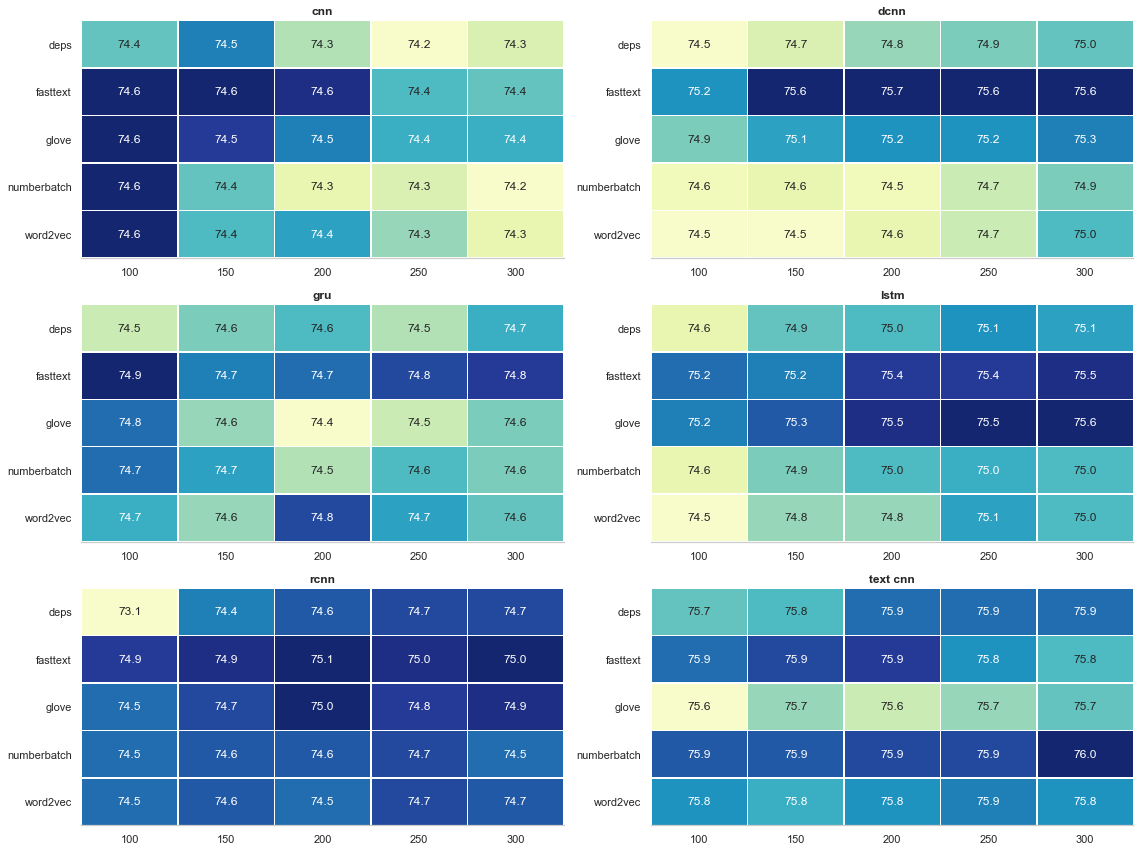

In [19]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform Two-way ANOVA for each model, comparing different embedding type and dimension groups.

In [20]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Levene test for equal variance
levene_test(embed_data, 'embedding_params', metric)

# Run Two-way ANOVA
two_way_anova_test(embed_data, 'embedding_dim', 'embedding_type', metric, show_result=True)

The following embedding_params are not normally distributed.
    model_name embedding_params    t-stat       p-value
24         cnn        glove_150  0.798237  1.380062e-02
41    text cnn  numberbatch_250  0.843851  4.906363e-02
49    text cnn     word2vec_150  0.831870  3.524159e-02
58        dcnn  numberbatch_100  0.842730  4.757236e-02
63        dcnn     word2vec_250  0.814990  2.203972e-02
66        dcnn     word2vec_150  0.840200  4.436784e-02
72        dcnn     fasttext_200  0.843929  4.916905e-02
75        rcnn  numberbatch_300  0.650402  2.219227e-04
80        rcnn         deps_300  0.728703  1.964893e-03
81        rcnn         deps_100  0.443029  7.864205e-07
84        rcnn         deps_150  0.794356  1.237940e-02
86        rcnn        glove_100  0.823439  2.788741e-02
87        rcnn     fasttext_100  0.836128  3.964889e-02
98        rcnn        glove_300  0.796981  1.332367e-02
103       lstm     word2vec_150  0.778495  7.936632e-03
104       lstm        glove_250  0.836990  

,model_name,exp_params,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
0,cnn,C(embedding_dim),1.958277,4.0,0.489569,12.082762,6.501529e-09,0.153008,0.139902
1,cnn,C(embedding_type),1.182589,4.0,0.295647,7.296689,1.528966e-05,0.092400,0.079485
2,cnn,C(embedding_dim):C(embedding_type),0.541128,16.0,0.033821,0.834703,6.453150e-01,0.042280,-0.008346
3,text cnn,C(embedding_dim),0.158393,4.0,0.039598,0.750999,5.582713e-01,0.010856,-0.003586
4,text cnn,C(embedding_type),2.021419,4.0,0.505355,9.584295,3.572011e-07,0.138543,0.123641
5,text cnn,C(embedding_dim):C(embedding_type),0.547068,16.0,0.034192,0.648463,8.417759e-01,0.037495,-0.020253
6,dcnn,C(embedding_dim),5.848027,4.0,1.462007,31.920076,4.576958e-21,0.124477,0.120460
7,dcnn,C(embedding_type),29.247534,4.0,7.311884,159.640756,1.631945e-64,0.622542,0.618040
8,dcnn,C(embedding_dim):C(embedding_type),1.579799,16.0,0.098737,2.155740,7.232518e-03,0.033626,0.018010
9,rcnn,C(embedding_dim),8.408383,4.0,2.102096,3.287203,1.210895e-02,0.047514,0.032940


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

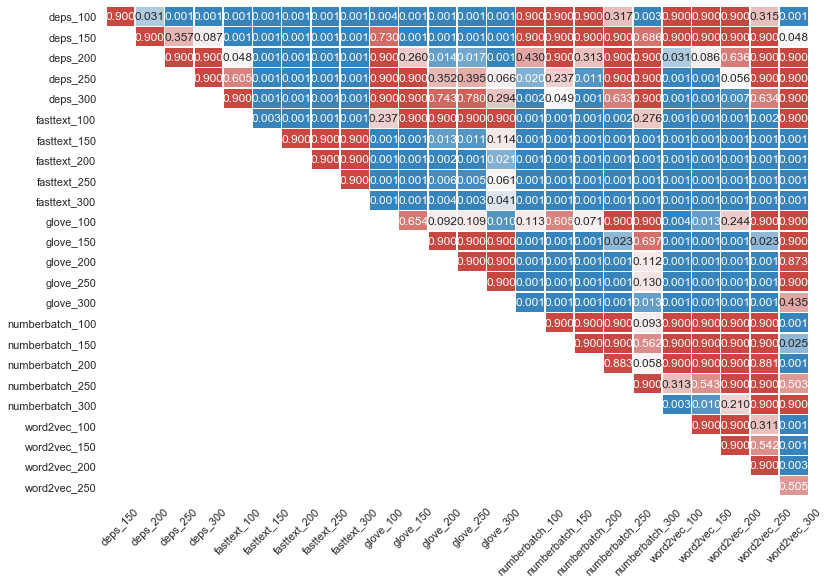

In [21]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(embed_data, 'embedding_params', metric, show_result=False)

# Generate heatmap
# g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
#                         title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
#                         annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
#                         y_tick_rotation=0, x_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# TODO this makes a heatmap for just one model
tukey_frame = tukey_frame[tukey_frame['model_name'] == 'dcnn']
tukey_frame = tukey_frame.drop(tukey_frame.columns.difference(['group1', 'group2', 'p-value']), axis=1)
tukey_frame = pd.pivot_table(tukey_frame, values='p-value', index='group1', columns='group2')

fig = plot_heatmap(tukey_frame, title='', y_label='', x_label='', colour='RdBu_r', custom_boundaries=[0.0, 0.05, 1.0],
                      center_val=None, show_cbar=False,num_format='.3f', linewidth=0.5, x_tick_rotation=45)

# TODO Attentional / multi-layer models / CRF

# Language Models

Using pre-trained language models to generate sequence representations.

In [22]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
1    roberta  78.166262     0.333614
Best test accuracy in mean data:
  model_name  test_acc  test_acc_std  f1_micro  f1_micro_std
1    roberta  76.21721      0.555866   0.76227      0.005539


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bert,76.869445,0.236433,76.067870,0.417505,0.762099,0.004058
1,roberta,78.166262,0.333614,76.217210,0.555866,0.762270,0.005539
2,gpt2,77.472497,0.438048,75.155674,0.624521,0.751557,0.006245
3,dialogpt,77.820908,0.436767,75.300318,0.374531,0.753003,0.003745
4,xlnet,78.154037,0.463679,75.883794,0.451465,0.758838,0.004515
5,convert,76.538991,0.220862,74.306640,0.343769,0.744496,0.003503
6,elmo,75.999300,0.197109,73.189126,0.531039,0.733636,0.005290
7,use,76.203573,0.146725,73.506348,0.379568,0.736210,0.003809
8,mlstm char lm,75.777338,0.252030,73.475910,0.614072,0.736210,0.005965
9,nnlm,73.444347,0.072382,70.122884,0.261699,0.702206,0.002628


Plot accuracy of each language model.

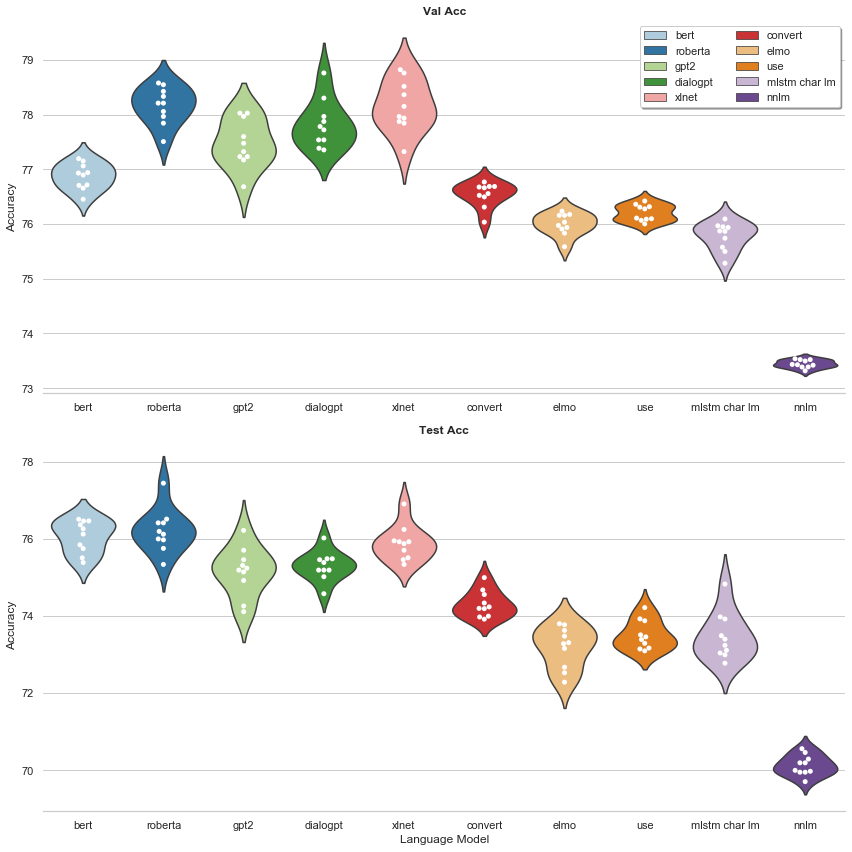

In [23]:
# TODO remove test data
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)

# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))